In [1]:
%matplotlib inline

In [4]:
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import time

import pathlib
import json
import numpy as np
import time
import matplotlib.pyplot as plt


In [ ]:
def load_head_data(experiments_path):
    head_data = {}
    for task_dir in experiments_path.iterdir():
        head_data[task_dir.stem] = {}
        for seed_dir in task_dir.iterdir():
            head_mask = np.load(seed_dir / "head_mask.npy")
            head_importance = np.load(seed_dir / "head_importance.npy")
            head_data[task_dir.stem][seed_dir.stem] = {
                "head_mask": head_mask,
                "importance": head_importance
            }
    return head_data
def load_mlp_data(experiments_path):
    mlp_data = {}
    for task_dir in experiments_path.iterdir():
        mlp_data[task_dir.stem] = {}
        for seed_dir in task_dir.iterdir():
            mlp_mask = np.load(seed_dir / "mlp_mask.npy")
            mlp_importance = np.load(seed_dir / "mlp_importance.npy")
            mlp_data[task_dir.stem][seed_dir.stem] = {
                "mlp_mask": mlp_mask,
                "importance": mlp_importance
            }
    return mlp_data
def plot_all_task_metrics(metrics, title):
    for name in metrics[0][1].keys():
        plot_task_metrics(analyzed_metrics, name, title)


def plot_matrix(mean_matrix, stddv_matrix, x_labels, y_labels, save_path, x_title='', y_title='', colour_map=plt.cm.OrRd):
    fig, ax = plt.subplots(figsize=(9,8))
    ax.set_xlabel(x_title, labelpad=20)
    ax.set_ylabel(y_title)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.set_xticks(range(len(x_labels)))
    ax.set_yticks(range(len(y_labels)))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    ax.imshow(mean_matrix, cmap=colour_map)
    plt.tight_layout()
    for i in range(len(mean_matrix)):
        for j in range(len(mean_matrix[0])):
            mean = mean_matrix[i, j]
            std =  stddv_matrix[i, j]
            ax.text(j, i, f"{mean:.2f}\n{std:.2f}", va='center', ha='center')
    if save_path:
        fig.savefig(save_path, bbox_inches='tight')
    plt.show()

def show_heads_heatmap(head_data, save_name):
    tasks = sorted(list(head_data.keys()))
    seeds = head_data[tasks[0]].keys()
    
#     pruned_head_results = np.zeros((len(tasks) * len(seeds), 12, 12)) # 12 layers with 12 heads each
#     i = 0
#     for seed_idx, seed in enumerate(seeds):
#         for task_idx, task in enumerate(tasks):
#             pruned_head_results[i] = head_data[task][seed]["head_mask"]
#             i += 1
    
    pruned_head_results = np.zeros((len(seeds), 12, 12)) # 12 layers with 12 heads each
    for task_idx, task in enumerate(tasks):
        for seed_idx, seed in enumerate(seeds):
            pruned_head_results[seed_idx] += head_data[task][seed]["head_mask"]
    mean_pruned_heads = np.mean(pruned_head_results, axis=0)
    std_pruned_heads = np.std(pruned_head_results, axis=0, ddof=1)
    plot_matrix(mean_pruned_heads, std_pruned_heads, list(map(str, range(12))), list(map(str, range(12))), save_name, "Head", "Layer")
    print("mean_survival_mean", mean_pruned_heads.mean())
    print("mean_survival_std", std_pruned_heads.mean())
    print("stable heads in 5 tasks or more/total surviving heads", (mean_pruned_heads > 5).sum()/(mean_pruned_heads > 0).sum())
    
    
def show_mlps_heatmap(mlp_data, save_name):
    tasks = sorted(list(mlp_data.keys()))
    seeds = mlp_data[tasks[0]].keys()
    
#     pruned_mlps_results = np.zeros((len(tasks) * len(seeds), 1, 12)) # 12 layers with 12 heads each
#     i = 0
#     for seed_idx, seed in enumerate(seeds):
#         for task_idx, task in enumerate(tasks):
#             pruned_mlps_results[i] = mlp_data[task][seed]["mlp_mask"]
#             i += 1
    
    pruned_mlps_results = np.zeros((len(seeds), 1, 12)) # 12 layers
    for task_idx, task in enumerate(tasks):
        for seed_idx, seed in enumerate(seeds):
            pruned_mlps_results[seed_idx] += mlp_data[task][seed]["mlp_mask"]
    mean_pruned_mlps = np.mean(pruned_mlps_results, axis=0)
    std_pruned_mlps = np.std(pruned_mlps_results, axis=0, ddof=1)
    plot_matrix(mean_pruned_mlps, std_pruned_mlps, list(map(str, range(12))), [], save_name, "Layer", "")
    print("mean_survival_mean", mean_pruned_mlps.mean())
    print("mean_survival_std", std_pruned_mlps.mean())
    print("stable mlps in 5 tasks or more/total surviving mlps", (mean_pruned_mlps > 5).sum() / (mean_pruned_mlps > 0).sum())

    
def show_task_specific_heads_heatmap(head_data, directory, save_suffix):
    tasks = sorted(list(head_data.keys()))
    seeds = head_data[tasks[0]].keys()
    for task in tasks:
        print(task)
        pruned_head_results = np.zeros((len(seeds), 12, 12)) # 12 layers with 12 heads each
        for seed_idx, seed in enumerate(seeds):
            pruned_head_results[seed_idx] += head_data[task][seed]["head_mask"]
            print(f"seed - {seed}  Surviving heads - {head_data[task][seed]['head_mask'].sum()}")
        mean_pruned_heads = np.mean(pruned_head_results, axis=0)
        std_pruned_heads = np.std(pruned_head_results, axis=0, ddof=1)

        plot_matrix(mean_pruned_heads, std_pruned_heads, list(map(str, range(12))), list(map(str, range(12))), f"{directory}/{task}_{save_suffix}", "Head", "Layer")
        print("mean_survival_mean", mean_pruned_heads.mean())
        print("mean_survival_std", std_pruned_heads.mean())
        print("stable heads/total surviving heads", (mean_pruned_heads == 1.0).sum() / (mean_pruned_heads > 0).sum())

def show_task_specific_mlp_heatmap(mlp_data, directory, save_suffix):
    tasks = sorted(list(mlp_data.keys()))
    seeds = mlp_data[tasks[0]].keys()
    for task in tasks:
        print(task)
        pruned_mlps_results = np.zeros((len(seeds), 1, 12)) # 12 layers
        for seed_idx, seed in enumerate(seeds):
            pruned_mlps_results[seed_idx] += mlp_data[task][seed]["mlp_mask"]
            print(f"seed - {seed}  Surviving MLPs - {mlp_data[task][seed]['mlp_mask'].sum()}")
        mean_pruned_mlps = np.mean(pruned_mlps_results, axis=0)
        std_pruned_mlps = np.std(pruned_mlps_results, axis=0, ddof=1)

        plot_matrix(mean_pruned_mlps, std_pruned_mlps, list(map(str, range(12))), [], f"{directory}/{task}_{save_suffix}", "Layer", "")
    
        print("mean_survival_mean", mean_pruned_mlps.mean())
        print("mean_survival_std", std_pruned_mlps.mean())
        print("stable mlps / total surviving mlps", (mean_pruned_mlps == 1.0).sum() / (mean_pruned_mlps > 0).sum())

# def show_heads_heatmap_1(head_data, save_name):
#     tasks = sorted(list(head_data.keys()))
#     seeds = head_data[tasks[0]].keys()
#     pruned_head_results = np.zeros((len(tasks), 12, 12)) # 12 layers with 12 heads each
    
#     for seed_idx, seed in enumerate(seeds):
#         for task_idx, task in enumerate(tasks):
#             pruned_head_results[task_idx] += head_data[task][seed]["head_mask"]
    
#     mean_pruned_heads = np.mean(pruned_head_results, axis=0) / len(seeds)
#     std_pruned_heads = np.std(pruned_head_results, axis=0, ddof=1) / len(seeds)
#     plot_matrix(mean_pruned_heads, std_pruned_heads, list(map(str, range(12))), list(map(str, range(12))), save_name, "Head", "Layer")


In [5]:
exp = pathlib.Path("../masks/global/")
masks = load_mask_data(exp)

WNLI
Average surviving weights across seeds: 0.4757007956504822
HEAD


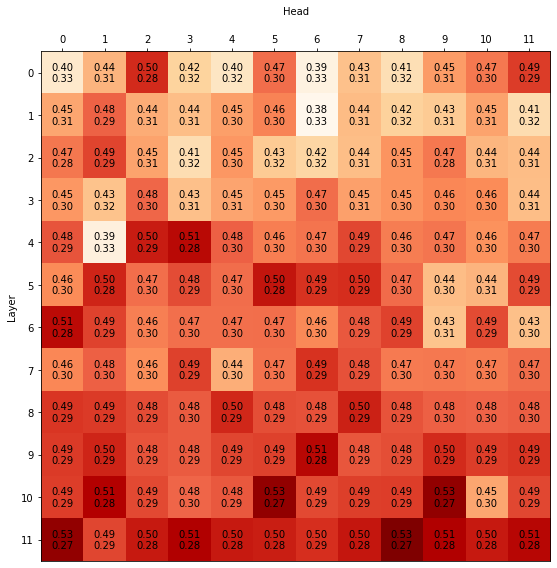

MLP


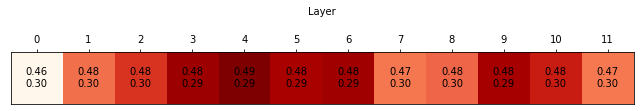

MRPC
Average surviving weights across seeds: 0.5645498633384705
HEAD


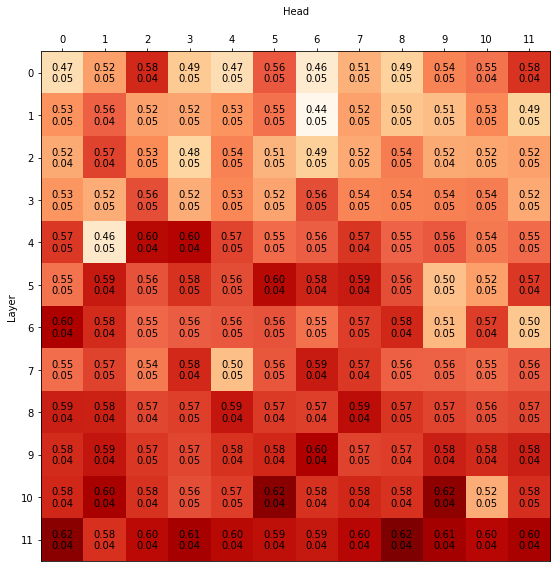

MLP


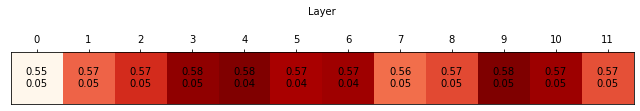

MNLI
Average surviving weights across seeds: 0.513342022895813
HEAD


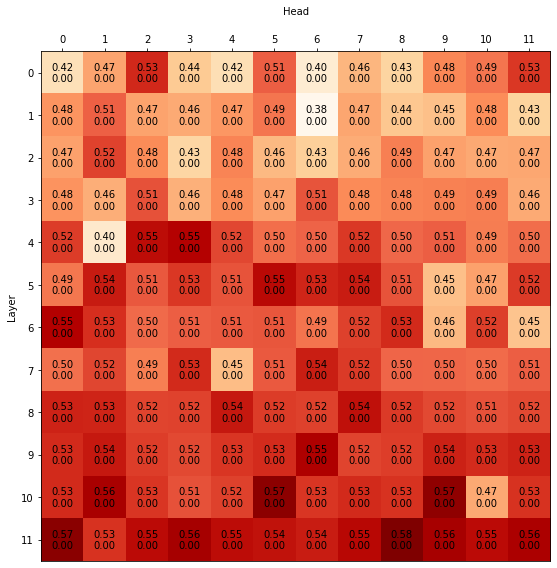

MLP


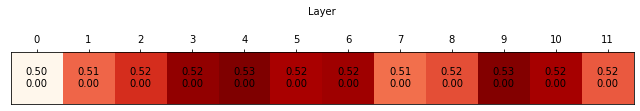

QQP
Average surviving weights across seeds: 0.4779214859008789
HEAD


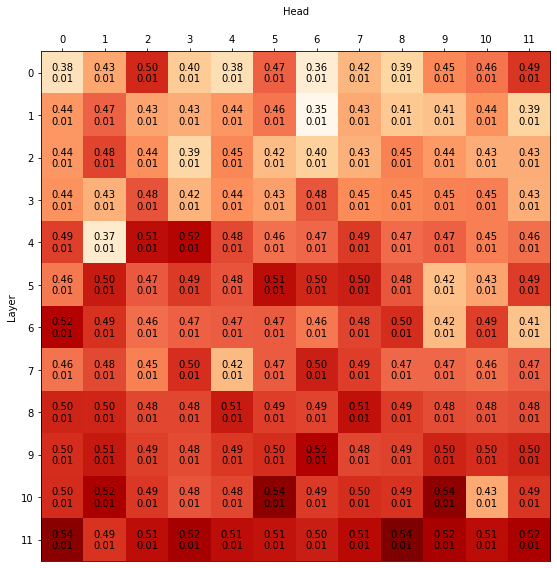

MLP


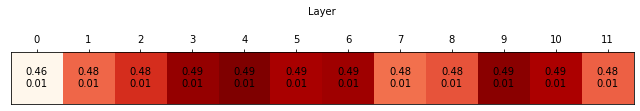

RTE
Average surviving weights across seeds: 0.5301074385643005
HEAD


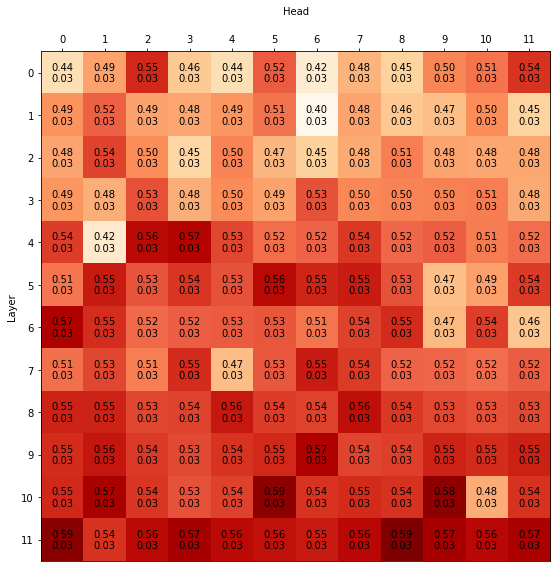

MLP


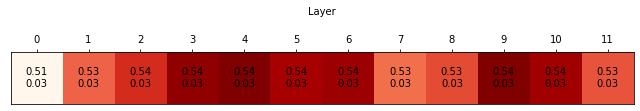

SST-2
Average surviving weights across seeds: 0.4357253909111023
HEAD


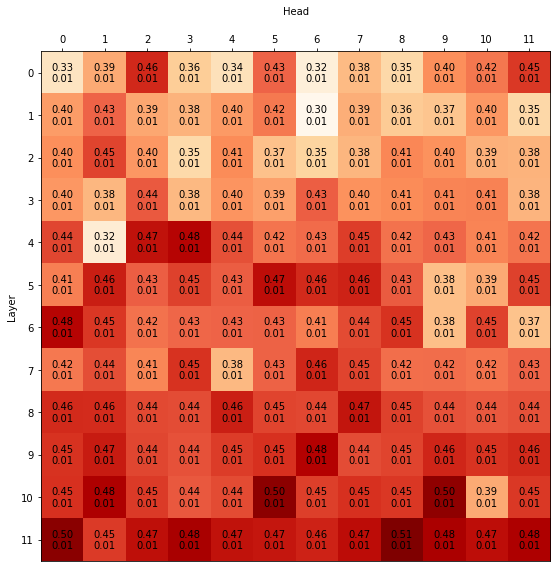

MLP


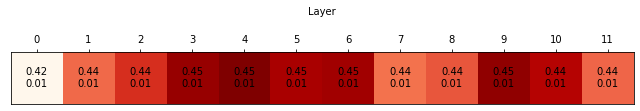

STS-B
Average surviving weights across seeds: 0.5033454298973083
HEAD


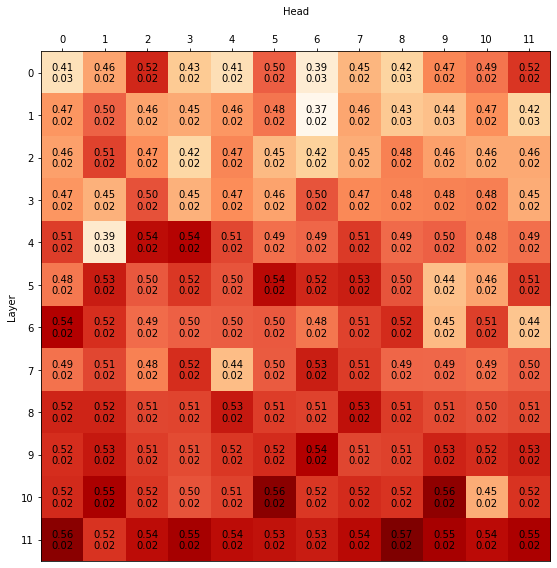

MLP


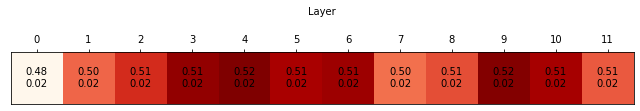

CoLA
Average surviving weights across seeds: 0.6355140209197998
HEAD


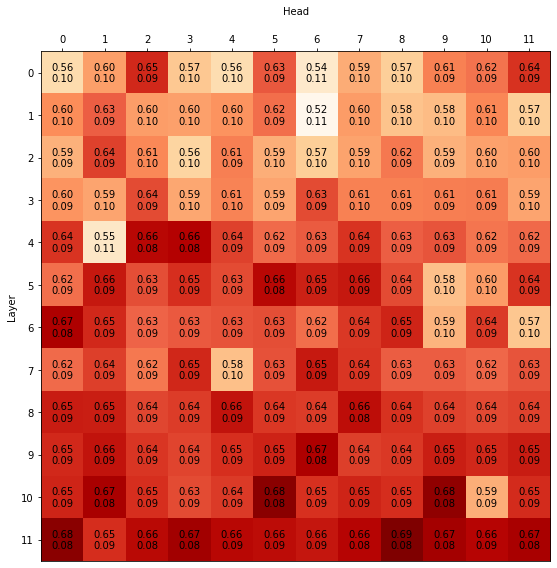

MLP


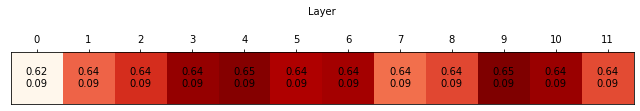

QNLI
Average surviving weights across seeds: 0.5295528173446655
HEAD


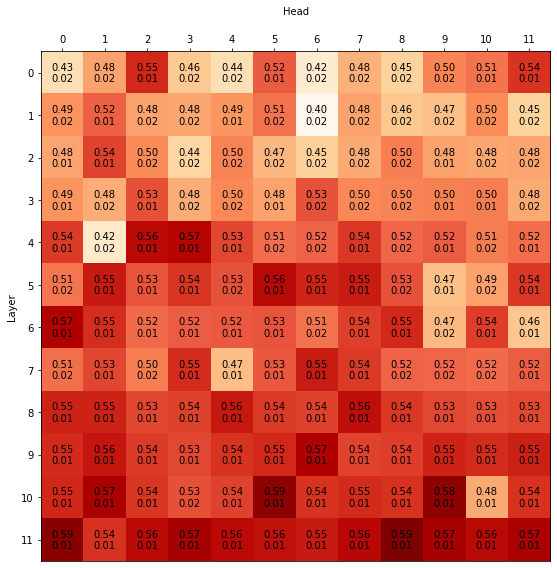

MLP


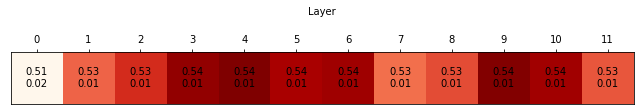

In [6]:
def task_wise_head_heatmaps(masks):
    for task in masks:
        layer_v_head = np.zeros((5, 12, 12))
        mlps = np.zeros((5,1, 12))
        print(task)
        print("Average surviving weights across seeds:", average_surviving_weights(task, masks))
        for seed_idx, seed in enumerate(masks[task]):
            mask =  masks[task][seed]
            for layer in range(12):
                mlps[seed_idx][0][layer] = find_active_weights_mlps(mask, layer)
                for head in range(12):
                    layer_v_head[seed_idx][layer][head] = find_active_weights_heads(mask, layer, head)
        mean_head = np.mean(layer_v_head, axis=0)
        std_head = np.std(layer_v_head, axis=0, ddof=1)
        print("HEAD")
        plot_matrix(mean_head, std_head, list(map(str, range(12))), list(map(str, range(12))), None, "Head", "Layer")
        mean_mlp = np.mean(mlps, axis=0)
        std_mlp = np.std(mlps, axis=0, ddof=1)
        print("MLP")
        plot_matrix(mean_mlp, std_mlp, list(map(str, range(12))), [], None, "Layer", "")

        
task_wise_head_heatmaps(masks)